In [30]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/data'

import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py

Mounted at /content/drive


In [31]:
# Read event_log from XES file and preprocess
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log

event_log = import_xes(dir + '/Sepsis.xes')

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [32]:
print(event_log.head())
print(event_log.columns)
print(event_log[['concept:name', 'case:concept:name', 'time:timestamp']])

  InfectionSuspected org:group DiagnosticBlood DisfuncOrg SIRSCritTachypnea  \
0               True         A            True       True              True   
1                NaN         B             NaN        NaN               NaN   
2                NaN         B             NaN        NaN               NaN   
3                NaN         B             NaN        NaN               NaN   
4                NaN         C             NaN        NaN               NaN   

  Hypotensie SIRSCritHeartRate Infusion DiagnosticArtAstrup     concept:name  \
0       True              True     True                True  ER Registration   
1        NaN               NaN      NaN                 NaN       Leucocytes   
2        NaN               NaN      NaN                 NaN              CRP   
3        NaN               NaN      NaN                 NaN       LacticAcid   
4        NaN               NaN      NaN                 NaN        ER Triage   

   ...  DiagnosticLacticAcid lifecycle:trans

In [33]:
# cols specifies the attributes which should be taken into account to compute the uniqueness
def compute_uniqueness(df, cols):
    amount_cases = df.shape[0]
    unique_values_in_column = df[cols].drop_duplicates().shape[0]
    uniqueness_of_col = round(unique_values_in_column / amount_cases, 4) * 100
    return uniqueness_of_col


def get_all_combinations(cols, max_combi_size, min_combi_size=1):
    all_column_combinations = []
    for r in range(min_combi_size, max_combi_size + 1):
        all_column_combinations.extend(product(cols, repeat=r))

    # Filter the list to keep only (x, y) and not (y, x)
    sorted_list = []
    for tuple in all_column_combinations:
        sorted_list.append(set(sorted(list(tuple))))

    unique_sets = set(frozenset(s) for s in sorted_list)

    # Convert back to a list
    unique_sets_list = list(unique_sets)

    return unique_sets_list

In [34]:
# Now let's focus on the uniqueness of traces
df_events_per_case = event_log.groupby('case:concept:name')['concept:name'].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
df_events_per_case

,case:concept:name,concept:name
0,A,"ER Registration, Leucocytes, CRP, LacticAcid, ..."
1,AA,"ER Registration, ER Triage, ER Sepsis Triage, ..."
2,AAA,"ER Registration, ER Triage, ER Sepsis Triage, ..."
3,AB,"ER Registration, ER Triage, ER Sepsis Triage, ..."
4,ABA,"ER Registration, ER Triage, ER Sepsis Triage, ..."
...,...,...
1045,ZV,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1046,ZW,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1047,ZX,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1048,ZY,"ER Registration, ER Triage, ER Sepsis Triage, ..."


In [35]:
uniqueness_of_traces = compute_uniqueness(df_events_per_case, 'concept:name')
print("{} %".format(uniqueness_of_traces))

80.57 %


In [36]:
# Compute the uniqueness of each activity --> With which probability can I reidentify a case (trace) given that a specific activity is contained in the trace
total_amount_traces = df_events_per_case.shape[0]
total_amount_events = event_log['concept:name'].unique().shape[0]
all_events = event_log['concept:name'].unique()
uniqueness_containing_activity = pd.DataFrame(all_events, columns=['concept:name'])
counts = {}
appears = {}

def helper_count(row, activity_code):
    total_counts = str(row).count(str(activity_code))
    return 1 if total_counts > 0 else 0

for event in all_events:
    counts[str(event)] = int(df_events_per_case['concept:name'].apply(lambda row: str(row).count(str(event))).values.sum())
    appears[str(event)] = df_events_per_case['concept:name'].apply(lambda row: helper_count(row, event)).values.sum()

df_unique_events = pd.DataFrame([counts.keys(), counts.values(), appears.values()]).T
df_unique_events.columns = ['concept:name', 'total counts', 'containedInTrace']

# Compute uniqueness
df_unique_events['uniqueness'] = 1 - (df_unique_events['containedInTrace'] - 1) / total_amount_traces

df_unique_events.sort_values('uniqueness', ascending=False)

,concept:name,total counts,containedInTrace,uniqueness
15,Release E,6,6,0.995238
14,Release D,24,24,0.978095
13,Release C,25,25,0.977143
12,Release B,56,56,0.947619
11,Admission IC,117,110,0.89619
10,Return ER,294,294,0.720952
9,Release A,671,671,0.361905
6,IV Liquid,753,753,0.28381
8,Admission NC,1182,800,0.239048
7,IV Antibiotics,823,823,0.217143


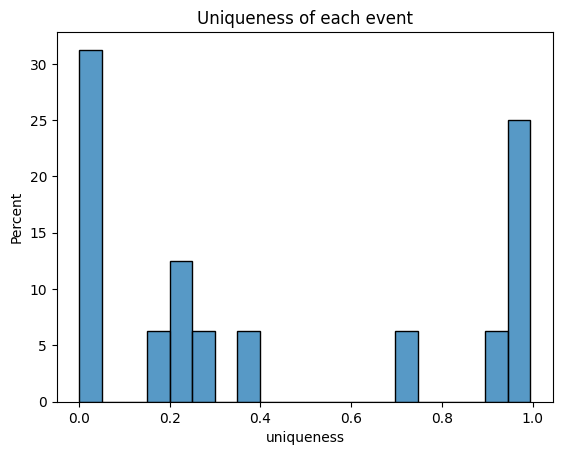

Bin 1 -  Count: 5, Percentage: 31.25 %
Bin 2 -  Count: 0, Percentage: 0.0 %
Bin 3 -  Count: 0, Percentage: 0.0 %
Bin 4 -  Count: 1, Percentage: 6.25 %
Bin 5 -  Count: 2, Percentage: 12.5 %
Bin 6 -  Count: 1, Percentage: 6.25 %
Bin 7 -  Count: 0, Percentage: 0.0 %
Bin 8 -  Count: 1, Percentage: 6.25 %
Bin 9 -  Count: 0, Percentage: 0.0 %
Bin 10 -  Count: 0, Percentage: 0.0 %
Bin 11 -  Count: 0, Percentage: 0.0 %
Bin 12 -  Count: 0, Percentage: 0.0 %
Bin 13 -  Count: 0, Percentage: 0.0 %
Bin 14 -  Count: 0, Percentage: 0.0 %
Bin 15 -  Count: 1, Percentage: 6.25 %
Bin 16 -  Count: 0, Percentage: 0.0 %
Bin 17 -  Count: 0, Percentage: 0.0 %
Bin 18 -  Count: 0, Percentage: 0.0 %
Bin 19 -  Count: 1, Percentage: 6.25 %
Bin 20 -  Count: 4, Percentage: 25.0 %

0 activities are completely unique


In [37]:
def print_and_visualize_hist_plot(df, col_name, amount_bins, hist_title, total_amount):

    sns.histplot(df[col_name], bins=amount_bins, stat='percent').set(title=hist_title)
    plt.show()

    hist_values, bin_edges = np.histogram(df[col_name], bins=amount_bins)

    # Print out the histogram values
    for i in range(len(hist_values)):
        print(f"Bin {i+1} -  Count: {hist_values[i]}, Percentage: {round(hist_values[i]/total_amount, 4) * 100} %")

    # Count of activities which have a uniqueness of 100%
    amount_completely_unique_activities = df[df[col_name] == 1][col_name].count()
    print("\n{} activities are completely unique".format(amount_completely_unique_activities))

print_and_visualize_hist_plot(df=df_unique_events, col_name='uniqueness', amount_bins=20, hist_title='Uniqueness of each event',total_amount=total_amount_events)

In [38]:
# unique traces in the event log not considering the order of execution of the activities and how many times each activity was executed

df_activites_per_case_as_set = df_events_per_case
# Convert String to list, then to set to remove duplicates and then convert set back to list to order the elements. Finally, convert list back to a String
df_activites_per_case_as_set['Ordered Event Set'] = df_events_per_case['concept:name'].apply(lambda row: ", ".join(sorted(list(set(row.split(", "))))))

# Compute Uniqueness
unordered_set_uniquness_of_activities = compute_uniqueness(df_activites_per_case_as_set, cols=['Ordered Event Set'])
print("{} % of traces are unique not considering the order of execution of the activities and how many times each activity was executed".format(unordered_set_uniquness_of_activities))

6.1899999999999995 % of traces are unique not considering the order of execution of the activities and how many times each activity was executed


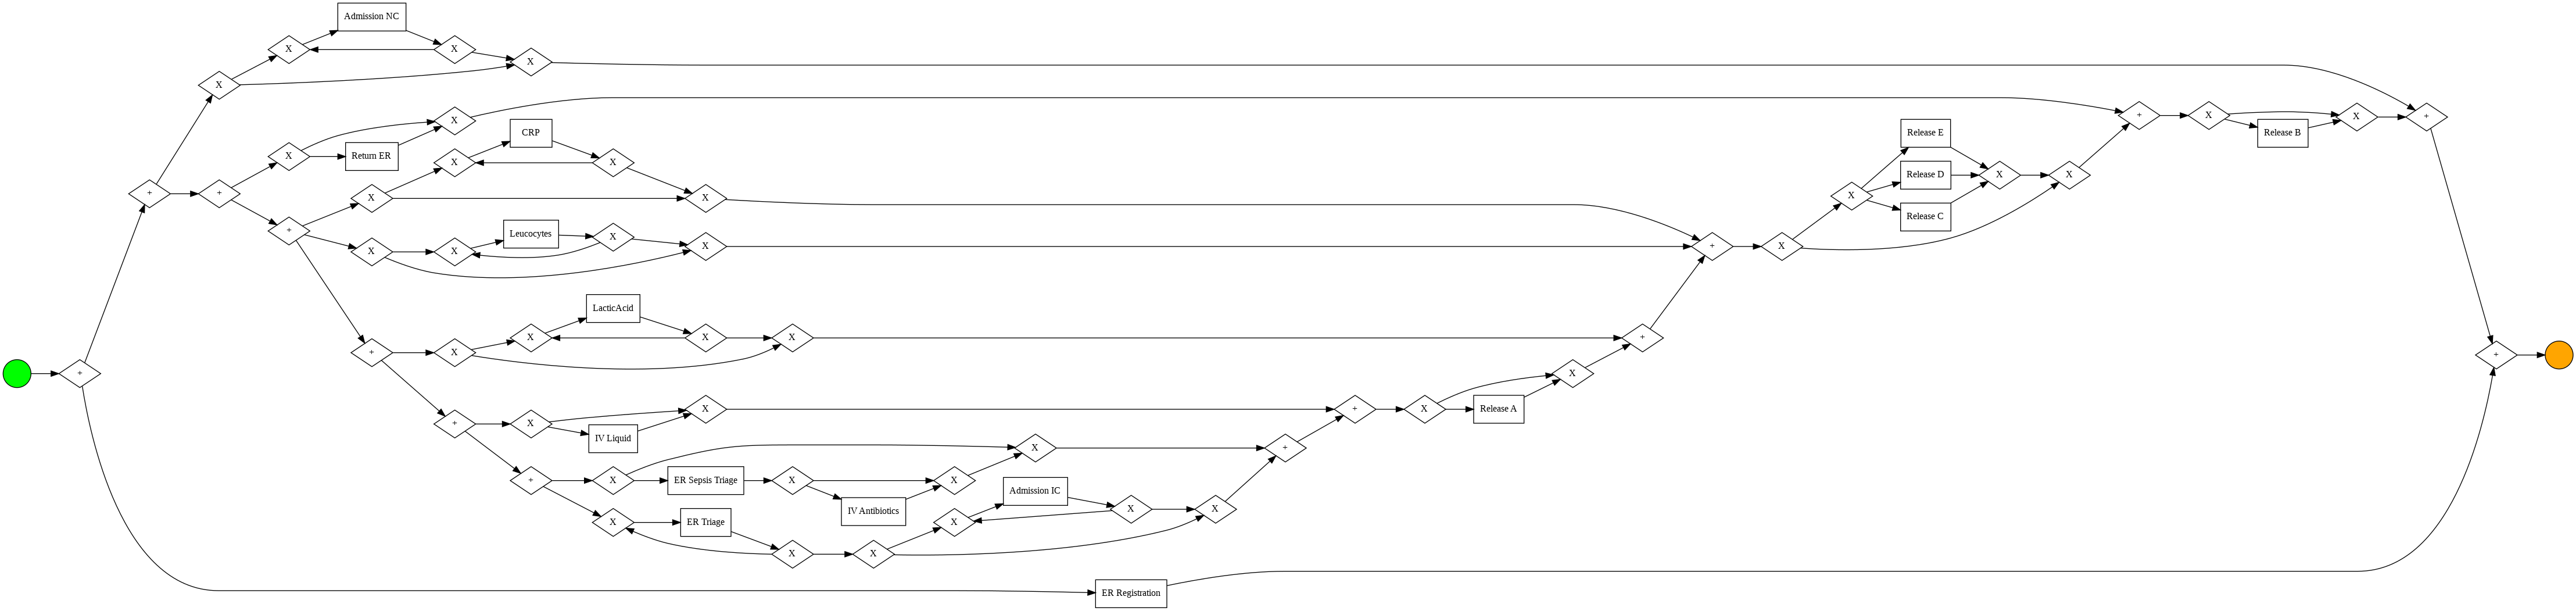

In [39]:
process_tree = pm4py.discover_process_tree_inductive(log=event_log, activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

In [40]:
# Aggregate all attributes of the event log
event_log_case_specific = event_log.groupby('case:concept:name').agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()

In [41]:
# Get all column combinations up to a maximum amount of columns

# Remove some columns
event_log_case_specific = event_log_case_specific.drop(columns=['time:timestamp', 'org:group', 'concept:name', 'lifecycle:transition'])
all_column_combinations = get_all_combinations(cols=event_log_case_specific.columns, max_combi_size=2)

# Calculate uniqueness for each combination
uniqueness_of_col_combinations = {}
for columns in all_column_combinations:
    uniqueness = compute_uniqueness(event_log_case_specific, list(columns))
    uniqueness_of_col_combinations[columns] = uniqueness

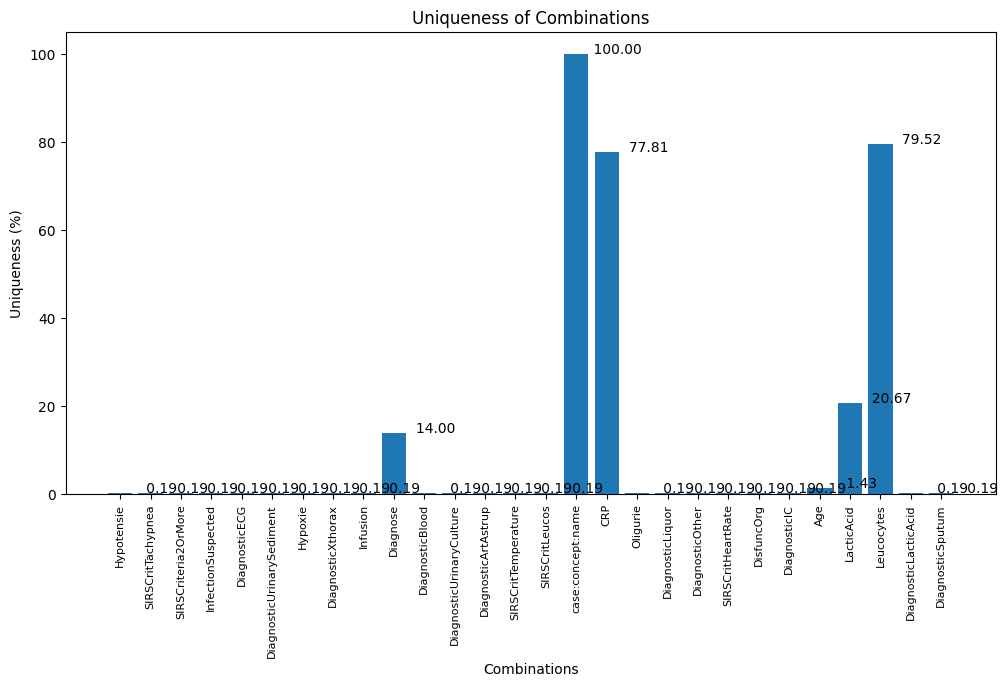

In [42]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],"{:10.2f}".format(y[i]))

filtered_dict = {key: value for key, value in uniqueness_of_col_combinations.items() if len(key) == 1}
combinations, values = zip(*filtered_dict.items())
plt.figure(figsize=(12, 6))
plt.bar(range(len(combinations)), values, align='center')
plt.xticks(range(len(combinations)), [', '.join(combination) for combination in combinations], rotation=90, fontsize=8)
plt.xlabel('Combinations')
plt.ylabel('Uniqueness (%)')
plt.title('Uniqueness of Combinations')
addlabels(combinations, values)
plt.show()

<ipython-input-43-6e89b55d8a1e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_columns.loc[:, 'Combination'] = df_two_columns.loc[:, 'Combination'].apply(sorted).copy()


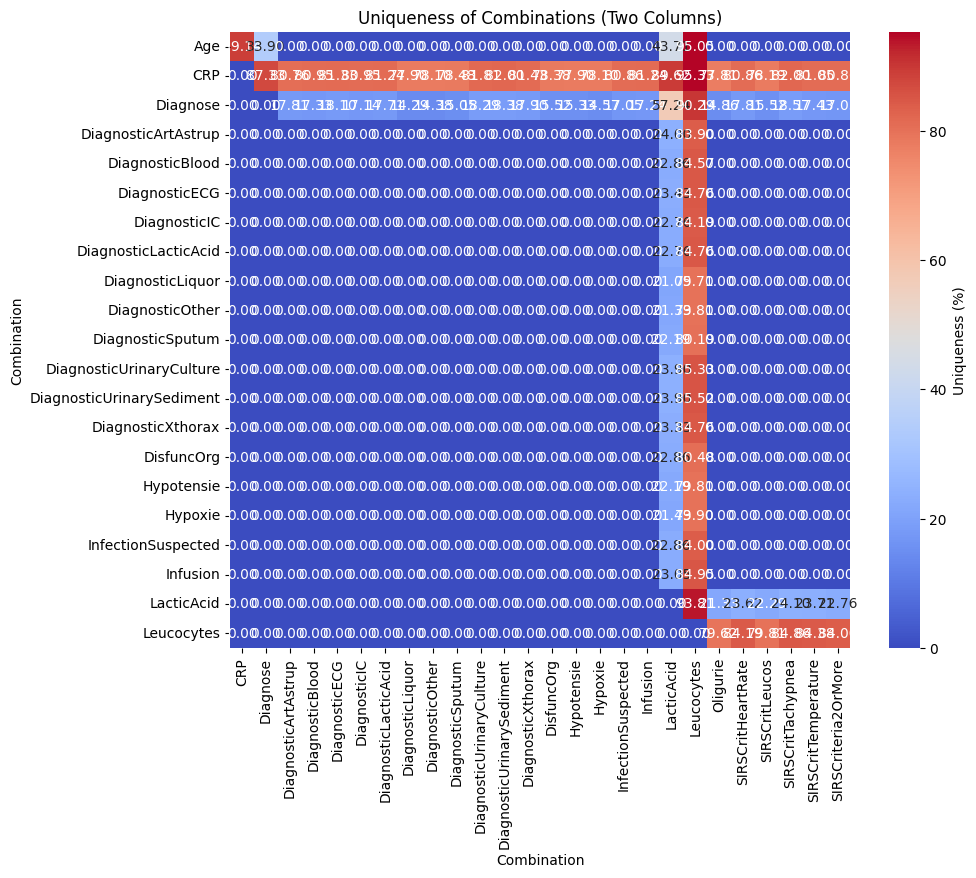

In [43]:
# Lets visualize the uniqueness of combinations of 2 columns
df = pd.DataFrame(list(uniqueness_of_col_combinations.items()), columns=['Combination', 'Uniqueness'])

# Extract combinations of size 2
df_two_columns = df[df['Combination'].apply(len) == 2]
df_two_columns.loc[:, 'Combination'] = df_two_columns.loc[:, 'Combination'].apply(sorted).copy()
df_two_columns = df_two_columns[(df_two_columns['Uniqueness'] > 5) & (df_two_columns['Uniqueness'] < 100)]

# Create a pivot table for the heatmap
heatmap_data = df_two_columns.pivot_table(index=df_two_columns['Combination'].apply(lambda x: x[0]),
                                          columns=df_two_columns['Combination'].apply(lambda x: x[1]),
                                          values='Uniqueness').fillna(0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Uniqueness (%)'})
plt.title('Uniqueness of Combinations (Two Columns)')
plt.show()

In [44]:
df[(df['Uniqueness'] >70) & (df_two_columns['Uniqueness'] < 100)].sort_values('Uniqueness', ascending=False)

,Combination,Uniqueness
209,"(Leucocytes, CRP)",95.33
68,"(Leucocytes, Age)",95.05
331,"(Leucocytes, LacticAcid)",93.81
200,"(Leucocytes, Diagnose)",90.29
310,"(LacticAcid, CRP)",89.62
247,"(CRP, Age)",89.14
28,"(Diagnose, CRP)",87.33
1,"(Leucocytes, DiagnosticUrinarySediment)",85.52
232,"(Leucocytes, DiagnosticUrinaryCulture)",85.33
106,"(Leucocytes, Infusion)",84.95


In [45]:
binary_cols =  ['InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG']
col_combinations_of_specific_length = []
uniqueness_of_col_combinations_specific_length = []

for i in range (1, 6):
  combinations = get_all_combinations(cols=binary_cols, max_combi_size=i, min_combi_size=i)
  col_combinations_of_specific_length.append(combinations)
  uniqueness_of_col_combinations = {}
  for columns in combinations:
    uniqueness = compute_uniqueness(event_log_case_specific, list(columns))
    uniqueness_of_col_combinations[columns] = uniqueness
  uniqueness_of_col_combinations_specific_length.append(uniqueness_of_col_combinations)

In [46]:
df = pd.DataFrame(list(uniqueness_of_col_combinations.items()), columns=['Combination', 'Uniqueness'])
df.sort_values('Uniqueness', ascending=False).head()

,Combination,Uniqueness
3273,"(DiagnosticUrinarySediment, DiagnosticECG, Dia...",2.76
348,"(DiagnosticUrinarySediment, DiagnosticArtAstru...",2.76
242,"(InfectionSuspected, DiagnosticECG, Diagnostic...",2.76
1423,"(DiagnosticBlood, InfectionSuspected, Diagnost...",2.76
1683,"(DiagnosticECG, DiagnosticLacticAcid, Infusion...",2.76


In [47]:
event_log_case_specific[['DiagnosticUrinarySediment', 'DiagnosticECG', 'DiagnosticLacticAcid', 'Infusion', 'SIRSCritTachypnea']].drop_duplicates()

,DiagnosticUrinarySediment,DiagnosticECG,DiagnosticLacticAcid,Infusion,SIRSCritTachypnea
0,True,True,True,True,True
2,False,True,True,True,False
4,True,True,True,True,False
8,True,True,True,False,True
9,False,True,True,True,True
11,False,False,True,True,False
13,False,False,False,False,False
44,False,False,False,False,True
50,True,True,False,True,True
55,False,False,True,True,True
